In [1]:
#some of these maybe not needed anymore...
import numpy as np
import os
import cv2
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.feature import greycoprops, greycomatrix, graycoprops, graycomatrix
from skimage.measure import shannon_entropy
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, BatchNormalization, Reshape, AveragePooling2D, concatenate, Input
import keras
from sklearn.preprocessing import LabelEncoder
import keras.utils as ku
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import time
import warnings
from sklearn.neural_network import MLPRegressor
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path = "/content/drive/MyDrive/Skripsi Face Recognition CNN/ORL/"

imgs = [] #image matrix
labels = []

for filename in os.listdir(data_path):
    img = cv2.imread(data_path + filename,0)
    imgs.append(img)
    labels.append(os.path.splitext(filename)[0].split('_')[1])

In [3]:
dct_imgs = []

for img in imgs:
  dct = cv2.dct(np.float32(img))
  thresh = 0.25
  dct_lowfreq = dct * (np.abs(dct) < (thresh*np.max(dct)))
  # dct_lowfreq = dct[:8, :8]
  dct_imgs.append(np.uint8(dct_lowfreq))

In [4]:
def calculate_metric(P, weights):

    results = np.apply_over_axes( #apply a function repeatedly over multiple axes.
        np.sum, (P * weights), axes=(0, 1))[0, 0]

    return results

In [5]:
graycomatrices = []
# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[1], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):

    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    # Calculate ASM, contrast, correlation, homogeneity dan dissimilarity
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)

    # Calculate entropy
    feature.append(shannon_entropy(glcm[:, :, 0, 0]))
    feature.append(shannon_entropy(glcm[:, :, 0, 1]))
    feature.append(shannon_entropy(glcm[:, :, 0, 2]))
    feature.append(shannon_entropy(glcm[:, :, 0, 3]))

    (num_level, num_level2, num_dist, num_angle) = glcm.shape
    # Calculate properties related to autocorrelation
    i = np.arange(num_level).reshape((num_level, 1, 1, 1))
    j = np.arange(num_level).reshape((1, num_level, 1, 1))
    # Calculate autocorrelation
    autocorrelation = calculate_metric(glcm, i * j)
    feature.extend(autocorrelation[:,0])
    feature.extend(autocorrelation[:,1])
    feature.extend(autocorrelation[:,2])
    feature.extend(autocorrelation[:,3])

    feature.append(label)
    return feature

In [6]:
# ----------------- call calc_glcm_all_agls() for all GLCM feature ----------------------------------
glcm_feature = [ 'ASM','contrast','correlation', 'homogeneity', 'dissimilarity', 'entropy', 'autocorrelation']
properties = glcm_feature[:5]
glcm_all_agls=[]
for img, label in zip(dct_imgs,labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                               label,
                               props=properties)
                               )

In [7]:
columns = []
angles = ['0', '45', '90','135']
for name in glcm_feature :
    for ang in angles:
        columns.append(name + "_" + ang)

columns.append("label")

glcm_df = pd.DataFrame(glcm_all_agls, columns = columns)
glcm_df

,ASM_0,ASM_45,ASM_90,ASM_135,contrast_0,contrast_45,contrast_90,contrast_135,correlation_0,correlation_45,...,dissimilarity_135,entropy_0,entropy_45,entropy_90,entropy_135,autocorrelation_0,autocorrelation_45,autocorrelation_90,autocorrelation_135,label
0,0.002113,0.001968,0.002091,0.001971,22772.283152,28203.075949,30199.388427,27253.270776,0.161478,-0.038467,...,120.174830,0.429786,0.431336,0.434179,0.431026,15208.786594,12476.467621,11474.156962,12951.370207,11
1,0.002301,0.002190,0.002362,0.002111,21318.286413,29242.788296,32880.269439,28550.556045,0.218932,-0.071013,...,125.184553,0.418520,0.424103,0.419125,0.422812,16152.456341,12177.611447,10407.072875,12523.730875,11
2,0.004282,0.004407,0.004483,0.004451,29125.098732,27042.293341,26028.778300,30370.294808,-0.033796,0.040196,...,129.525408,0.361049,0.355725,0.357354,0.353318,11497.623551,12497.680793,13055.579024,10833.680059,10
3,0.002076,0.001958,0.002061,0.002029,21808.040036,28921.324344,32220.524051,28201.500275,0.194531,-0.068492,...,123.708310,0.425842,0.429241,0.427341,0.427461,15546.460145,11899.186204,10286.876673,12264.930655,11
4,0.002058,0.001896,0.002135,0.001923,23250.921558,27270.657311,32422.260759,27192.509081,0.146712,-0.000256,...,119.542653,0.416575,0.424700,0.422288,0.425356,14992.304348,12977.397725,10385.221700,13016.474225,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.005622,0.005572,0.005616,0.005652,29257.544928,26239.071180,29353.159132,27110.756925,-0.033462,0.074139,...,115.616217,0.344715,0.344323,0.344538,0.344622,11444.773188,12976.213722,11407.996383,12534.407265,10
396,0.008169,0.007568,0.007788,0.007739,26734.655435,26837.656026,27464.637794,27597.640800,0.040233,0.037747,...,117.793065,0.349311,0.348145,0.348893,0.344732,11376.238949,11364.514951,11070.985353,10984.523390,10
397,0.004358,0.004450,0.004476,0.004433,28252.587500,27808.035773,29233.791139,29520.306182,-0.009358,0.006638,...,126.277564,0.375058,0.371221,0.370839,0.367890,11747.883333,11948.350761,11215.544123,11098.087140,10
398,0.003953,0.004057,0.004260,0.003963,29467.648007,27292.690332,28005.286438,28439.718033,-0.048951,0.028874,...,121.963860,0.367374,0.367360,0.369766,0.365170,11643.979529,12728.794717,12361.098373,12161.199046,10


In [8]:
X = glcm_df.iloc[:,:-1]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
glcm_scaled = scaler.transform(X)

In [9]:
columns = []
angles = ['0', '45', '90','135']
for name in glcm_feature :
    for ang in angles:
        columns.append(name + "_" + ang)

pd.DataFrame(glcm_scaled, columns=columns)

,ASM_0,ASM_45,ASM_90,ASM_135,contrast_0,contrast_45,contrast_90,contrast_135,correlation_0,correlation_45,...,dissimilarity_90,dissimilarity_135,entropy_0,entropy_45,entropy_90,entropy_135,autocorrelation_0,autocorrelation_45,autocorrelation_90,autocorrelation_135
0,-0.748592,-0.767865,-0.762820,-0.770798,-1.669573,0.680250,0.563033,-0.628656,1.429462,-1.293619,...,0.868502,-0.048703,1.488076,1.576934,1.604825,1.578453,1.815457,0.418287,0.202552,1.036849
1,-0.711940,-0.722614,-0.709002,-0.742485,-2.370099,1.569197,1.803311,0.384478,2.214735,-2.077496,...,1.992561,0.914956,1.211404,1.400394,1.234691,1.378777,2.469008,0.166347,-0.592740,0.693981
2,-0.323879,-0.270813,-0.287645,-0.266238,1.391174,-0.312211,-1.366450,1.805630,-1.239522,0.601024,...,-1.378136,1.749953,-0.199900,-0.268618,-0.284059,-0.310709,-0.754759,0.436170,1.381178,-0.661050
3,-0.756005,-0.769747,-0.768801,-0.759114,-2.134139,1.294348,1.498087,0.111878,1.881218,-2.016768,...,1.741953,0.630989,1.391216,1.525786,1.436697,1.491796,2.049317,-0.068370,-0.682321,0.486483
4,-0.759533,-0.782397,-0.754153,-0.780726,-1.438968,-0.116961,1.591418,-0.676108,1.227635,-0.373274,...,1.788968,-0.170307,1.163649,1.414946,1.312457,1.440623,1.665529,0.840579,-0.609025,1.089047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.061665,-0.033598,-0.062342,-0.021714,1.454986,-0.998961,0.171535,-0.739954,-1.234953,1.418563,...,0.069156,-0.925587,-0.601002,-0.546925,-0.599157,-0.522131,-0.791361,0.839581,0.153243,0.702541
396,0.437078,0.373162,0.369089,0.403015,0.239473,-0.487175,-0.702166,-0.359715,-0.227702,0.542041,...,-0.738383,-0.506853,-0.488138,-0.453637,-0.492094,-0.519440,-0.838826,-0.519105,-0.097929,-0.540108
397,-0.308999,-0.262064,-0.289022,-0.269947,0.970803,0.342494,0.116311,1.141819,-0.905501,-0.207234,...,0.092878,1.125205,0.144129,0.109616,0.047508,0.043544,-0.581438,-0.026923,0.009810,-0.449056
398,-0.388298,-0.342277,-0.331902,-0.365472,1.556212,-0.098123,-0.452042,0.297918,-1.446659,0.328326,...,-0.434590,0.295431,-0.044586,0.015376,0.021118,-0.022572,-0.653398,0.631003,0.863585,0.403314


In [10]:
# X_train, X_test, y_train, y_test = train_test_split(glcm_scaled, labels, test_size=0.2, random_state=223)
# X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(imgs, labels, test_size=0.2, random_state=223)


#GLCM Features
# Split data into train-validation set and test set (80-20 split)
X_train_val, X_test, y_train_val, y_test = train_test_split(glcm_scaled, labels, test_size=0.2, stratify=labels, random_state=42)

# Split train-validation set into train set and validation set (75-25 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_val = np.array(y_val)
# y_test = np.array(y_test)

# Print the shapes of the resulting sets
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Training set: (240, 28)
Validation set: (80, 28)
Test set: (80, 28)


In [11]:
#Image
# Split data into train-validation set and test set (80-20 split)
X_train_val_img, X_test_img, y_train_val_img, y_test_img = train_test_split(imgs, labels, test_size=0.2, stratify=labels, random_state=42)

# Split train-validation set into train set and validation set (75-25 split)
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(X_train_val_img, y_train_val_img, test_size=0.25, stratify=y_train_val_img, random_state=42)

X_train_img = np.array(X_train_img)
X_val_img = np.array(X_val_img)
X_test_img = np.array(X_test_img)
# y_train_img = np.array(y_train_img)
# y_val_img = np.array(y_val_img)
# y_test_img = np.array(y_test_img)

# Print the shapes of the resulting sets
print("Training set:", X_train_img.shape)
print("Validation set:", X_val_img.shape)
print("Test set:", X_test_img.shape)

Training set: (240, 80, 70)
Validation set: (80, 80, 70)
Test set: (80, 80, 70)


In [12]:
# Encode labels
le = LabelEncoder()

train_labels_encoded = le.fit_transform(y_train)
y_train = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_val)
y_val = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_test)
y_test = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_train_img)
y_train_img = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_val_img)
y_val_img = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_test_img)
y_test_img = to_categorical(train_labels_encoded)

In [13]:
#For Image
def build_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape = (80, 70, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(units = 535, activation = 'relu'))
    model.add(Dense(units = 535, activation = 'relu'))
    model.add(Dropout(0.5))
    print(model.summary())
    return model

In [14]:
#For GLCM Features
def build_mlp():
    model = keras.Sequential([
        keras.Input(shape=28, name='Extracted_Traditional_Features'),
        keras.layers.Dense(370, activation=tf.keras.activations.relu, name='Dense0'),
        keras.layers.Dropout(0.25),
    ])
    print(model.summary())
    return model

In [15]:
#concatenate

mlp = build_mlp()
cnn = build_cnn()

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(40, activation="softmax")(combinedInput)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense0 (Dense)              (None, 370)               10730     
                                                                 
 dropout (Dropout)           (None, 370)               0         
                                                                 
Total params: 10,730
Trainable params: 10,730
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 68, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 34, 32)       0         
 )                                                               
                         

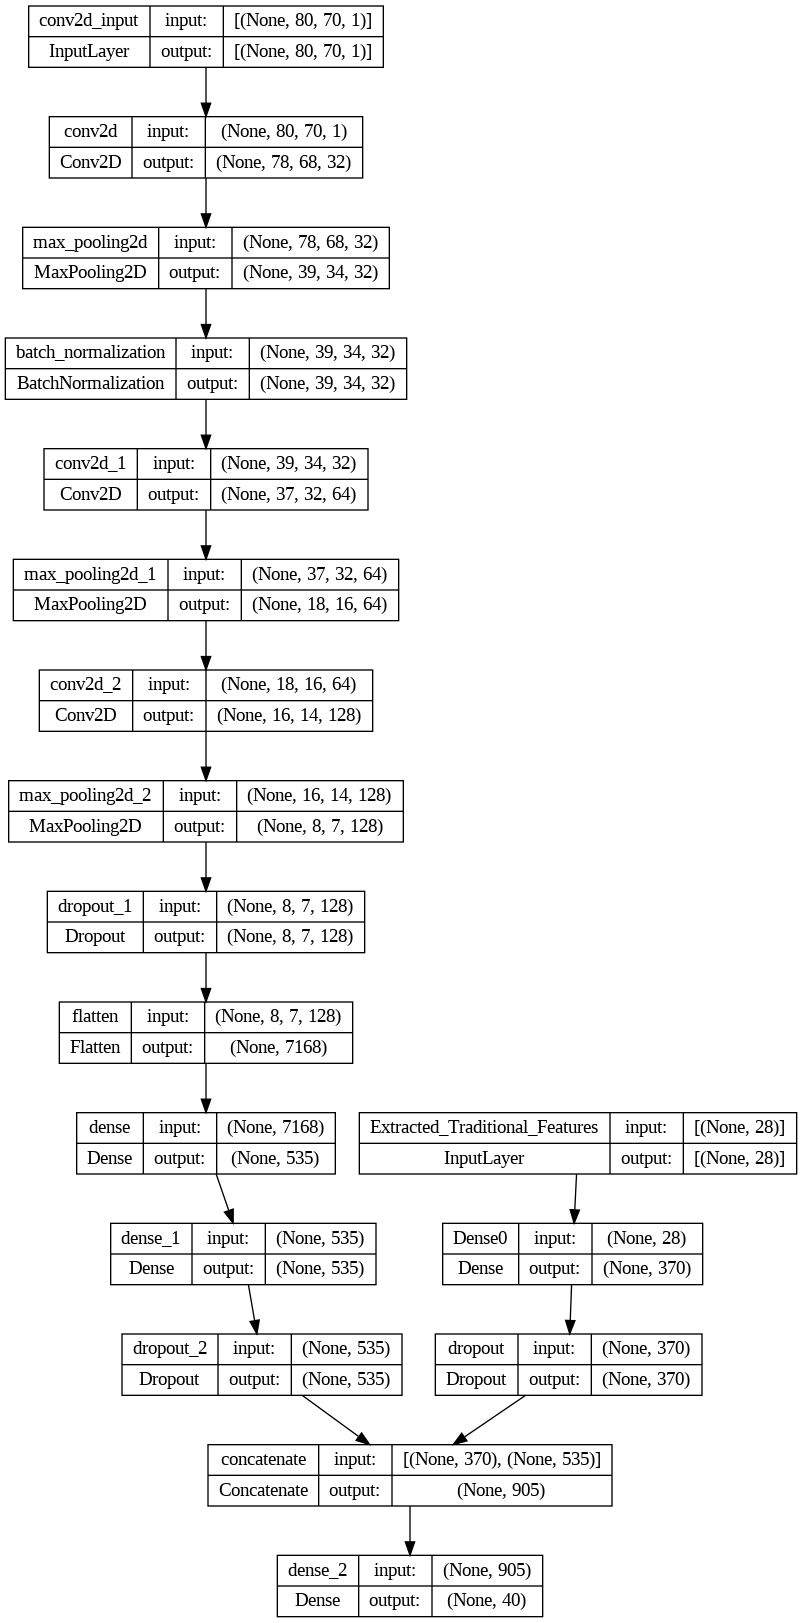

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('dct-weights.{epoch:02d}.h5', save_weights_only=True)


cb = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-8,
        verbose=1,
    ),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
    checkpoint
]

In [19]:
start = time.time()
history = model.fit([X_train, X_train_img], y_train_img, epochs=100, batch_size=16, validation_data=([X_val, X_val_img], y_val_img), callbacks = cb)
finish = time.time()


Epoch 1/100
15/15 [==============================] - 6s 255ms/step - loss: 3.9527 - accuracy: 0.0375 - val_loss: 3.9324 - val_accuracy: 0.0250 - lr: 1.0000e-04
Epoch 2/100
15/15 [==============================] - 4s 234ms/step - loss: 3.5944 - accuracy: 0.0542 - val_loss: 3.5984 - val_accuracy: 0.0625 - lr: 1.0000e-04
Epoch 3/100
15/15 [==============================] - 5s 316ms/step - loss: 3.3852 - accuracy: 0.1417 - val_loss: 3.4338 - val_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 4/100
15/15 [==============================] - 4s 282ms/step - loss: 3.0798 - accuracy: 0.2708 - val_loss: 3.2327 - val_accuracy: 0.1125 - lr: 1.0000e-04
Epoch 5/100
15/15 [==============================] - 3s 230ms/step - loss: 2.7234 - accuracy: 0.3375 - val_loss: 2.9199 - val_accuracy: 0.2625 - lr: 1.0000e-04
Epoch 6/100
15/15 [==============================] - 3s 221ms/step - loss: 2.4186 - accuracy: 0.4250 - val_loss: 2.7038 - val_accuracy: 0.2875 - lr: 1.0000e-04
Epoch 7/100
15/15 [=====================

In [20]:
print('Training time : ', str(finish-start), "second(s)")

Training time :  187.05957102775574 second(s)


In [21]:
start_test = time.time()
test_loss, test_acc = model.evaluate([X_test, X_test_img], y_test_img)
finish_test = time.time()
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Testing time : ', str(finish_test-start_test), "second(s)")

3/3 [==============================] - 0s 73ms/step - loss: 0.1512 - accuracy: 0.9625
Test loss: 0.15117591619491577
Test accuracy: 0.9624999761581421
Testing time :  0.5614404678344727 second(s)


In [22]:
# Extract features from the trained CNN model
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
train_features = feature_extractor.predict([X_train, X_train_img])
test_features = feature_extractor.predict([X_test, X_test_img])


3/3 [==============================] - 0s 71ms/step


In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(train_features, np.argmax(y_train, axis=1))
train_features_lda = lda.transform(train_features)
test_features_lda = lda.transform(test_features)

In [24]:
train_features_lda.shape

(240, 39)

In [25]:
classifier = Sequential()
classifier.add(Dense(40, activation='softmax', input_shape=(39,)))  # Number of classes = 10
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.fit(train_features_lda, y_train, batch_size=128, epochs=100, verbose=1)


Epoch 1/100
2/2 [==============================] - 0s 10ms/step - loss: 9.6000 - accuracy: 0.0667
Epoch 2/100
2/2 [==============================] - 0s 10ms/step - loss: 9.3186 - accuracy: 0.0750
Epoch 3/100
2/2 [==============================] - 0s 19ms/step - loss: 9.0485 - accuracy: 0.0792
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 8.7835 - accuracy: 0.0833
Epoch 5/100
2/2 [==============================] - 0s 7ms/step - loss: 8.5214 - accuracy: 0.0833
Epoch 6/100
2/2 [==============================] - 0s 10ms/step - loss: 8.2577 - accuracy: 0.0875
Epoch 7/100
2/2 [==============================] - 0s 12ms/step - loss: 8.0007 - accuracy: 0.0875
Epoch 8/100
2/2 [==============================] - 0s 9ms/step - loss: 7.7475 - accuracy: 0.0958
Epoch 9/100
2/2 [==============================] - 0s 8ms/step - loss: 7.4985 - accuracy: 0.1042
Epoch 10/100
2/2 [==============================] - 0s 9ms/step - loss: 7.2572 - accuracy: 0.1167
Epoch 11/100
2/2 [======

In [26]:
# Evaluate the classifier on test data
predictions = np.argmax(classifier.predict(test_features_lda), axis=1)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

3/3 [==============================] - 0s 4ms/step
Accuracy: 82.50%
